## importing the dependencies

In [9]:
#importing dependencies
import cv2
import os
import random
from matplotlib import pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## Set GPU growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Optionally, limit the maximum amount of GPU memory that can be allocated
            tf.config.experimental.set_limit_gpu_memory(gpu, 0.9 * tf.config.experimental.get_memory_usage(gpu))
    except RuntimeError as e:
        print(e)


## Create Directories

In [ ]:
POS_PATH = os.path.join('data','positive')
ANC_PATH = os.path.join('data','anchor')
NEG_PATH = os.path.join('data','negative')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

## Get the wild dataset into negative folder

In [ ]:
#uncompress the tar file 
!tar -xf lfw.tgz

In [ ]:
#moving the data from wild datset to negative folder
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw')):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        print(NEW_PATH)
        print(EX_PATH)
        os.replace(EX_PATH,NEG_PATH)

In [ ]:
#calling the function called as open_webcam in another .py file for computing efficiency
from subprocess import call 

def open_webcam():
    call(['python','webcam_test.py'])

open_webcam()

## Creating pipelines to access each file in the dataset

In [ ]:
##Get image directories 
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)     #this will get the paths of each jpg file and stores in the variables
postive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)      
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)   ##TYPICALLY THIS 3 LINES CREATES PIPELINES FOR 3 DATASTES    

In [ ]:
ANC_PATH+'/*.jpg'  # it gives the directory path to access the jpg files

'data/anchor/*.jpg'

In [ ]:
dir = anchor.as_numpy_iterator()    #it will iterate to the file path 

In [ ]:
dir.next()

b'data/anchor/223e27ec-2976-11ef-aaf7-8e5257c51906.jpg'

## preprocessing-->  Scale and Resize

In [ ]:
def preprocess(file_path):
    #Read in image from the file path 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    #resize the image to 100x100px
    img = tf.image.resize(img,(100,100))
    #Scale image to be between 0 & 1
    img = img/255.0
    
    return img

In [ ]:
img=preprocess('data/anchor/7d035e08-249a-11ef-af29-8e5257c51906.jpg')

In [ ]:
img.numpy().max()

1.0

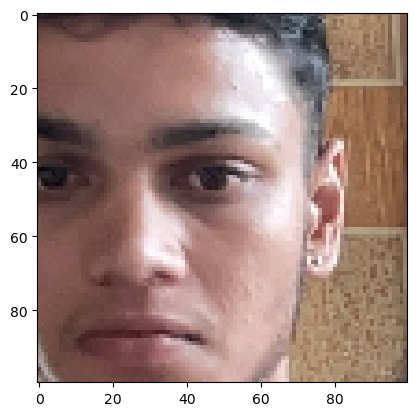

In [ ]:
plt.imshow(img)

In [ ]:
#dataset.map(preprocess)

## Create labelled Dataset

In [ ]:
positives = tf.data.Dataset.zip((anchor,postive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
sample.next()

(b'data/anchor/8bb58f02-249a-11ef-af29-8e5257c51906.jpg',
 b'data/positive/19b9128e-249a-11ef-91c3-8e5257c51906.jpg',
 1.0)

## Build train and validation partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img),label)

In [ ]:
#build dataset pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
res=sample.next()

In [ ]:
len(res)

3

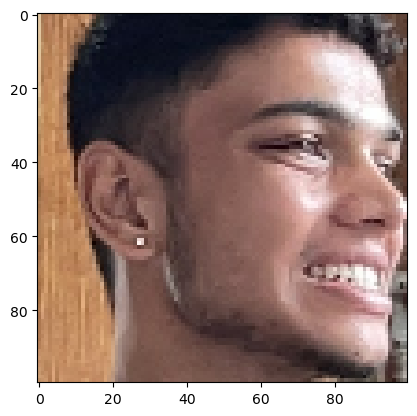

In [ ]:
plt.imshow(res[1])

In [ ]:
res[2]  # as we get the anchor and positive the label-------> 1.0
        #else_if we get anchor and negative the label-------> 0.0

1.0

In [ ]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
#training partition
train_data = data.take(round(len(data)*.7))   #considering 70% of data for training
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
train_samples = train_data.as_numpy_iterator()

In [ ]:
train_samples=train_samples.next()

In [ ]:
len(train_samples[0])

16

In [ ]:
#testing partition

test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))  #considering 30% of data for testing
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

## Building Embedding layer

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)  
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)  
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3) 
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs= inp, outputs= d1, name='embedding')

In [ ]:
embedding = make_embedding()

In [ ]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## Building Distance Layer

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Ensure both inputs are tensors
        if not (isinstance(input_embedding, tf.Tensor) and isinstance(validation_embedding, tf.Tensor)):
            raise ValueError("Both input_embedding and validation_embedding must be tensors.")
        
        # Calculate the absolute difference between input_embedding and validation_embedding
        l1_distance = tf.math.abs(input_embedding - validation_embedding)
        
        return l1_distance


## Make Siamese Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()

distances = siamese_layer(inp_embedding, val_embedding)

classifier = Dense(1, activation='sigmoid')(distances)

classifier


<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_12>

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

## Training


In [ ]:
#setup loss function
binary_cross_loss = tf.losses.BinaryCrossentropy(from_logits=False)


#setup optimizer
opt = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#creating checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [ ]:
test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
y = batch_1[2]

In [ ]:
# Define the training step function
def train_step(batch):
    with tf.GradientTape() as tape:
        # Perform forward pass
        y_pred = siamese_model(batch_1[:2]) 
        # Calculate loss
        loss = binary_cross_loss(batch_1[2], y_pred)
    
    # Calculate gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply gradients
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))
    
    return loss

## Train the model

In [ ]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
# Metrics calculation 
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating metric objects 
        r = tf.keras.metrics.Recall()
        p = tf.keras.metrics.Precision()
        
        # Reset states of metrics
        r.reset_state()  
        p.reset_state()  
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            y_pred = siamese_model.predict(batch_1[:2])  
            r.update_state(batch_1[2], y_pred)
            p.update_state(batch_1[2], y_pred) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
EPOCHS = 15

In [ ]:
#training the model
train(train_data, EPOCHS)   

Evaluate the model

In [ ]:
#import the metrics 
from tensorflow.keras.metrics import Precision,Recall

In [ ]:
test_input,test_val,y_true = test_data.as_numpy_iterator().next()

In [ ]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step


In [ ]:
y_hat

array([[0.498631  ],
       [0.49868804],
       [0.49743593],
       [0.4963176 ],
       [0.49880084],
       [0.49896953],
       [0.4980073 ],
       [0.49734268],
       [0.49777883],
       [0.49609625],
       [0.49912345],
       [0.4978449 ],
       [0.49835527],
       [0.4981569 ],
       [0.49658525],
       [0.4989395 ]], dtype=float32)

In [ ]:
#step to convert the values to 0 and 1 with the treshold 0.5
[1 if prediction>0.7 else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.],
      dtype=float32)

In [ ]:
m = Recall()

In [ ]:
m.update_state(y_true,y_hat)

In [ ]:
m.result().numpy()

0.0

In [ ]:
m = Precision()

In [ ]:
m.update_state(y_true,y_hat)

In [ ]:
m.result().numpy()    #it gives 90% efficiency

0.0

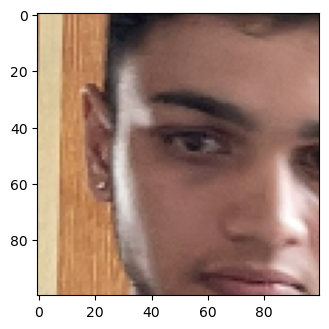

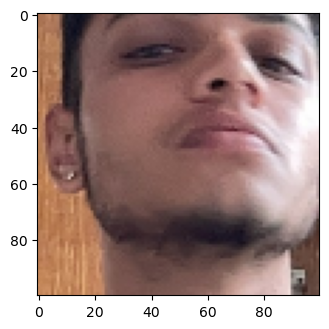

In [ ]:
#vizualize the images in the batches
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.imshow(test_val[0])

## Save the model

In [ ]:
siamese_model.save('siamesemodel.h5')

In [ ]:
L1Dist

__main__.L1Dist

## load the model

In [ ]:
#step to reload the saved model
model = tf.keras.models.load_model('siamesemodel.h5',custom_objects ={ 'L1Dist':L1Dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [91]:
#Predicting the values from the saved model
model.predict([test_input,test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step


array([[0.4988396 ],
       [0.49974993],
       [0.49936944],
       [0.499486  ],
       [0.49862787],
       [0.50105214],
       [0.49841306],
       [0.4977334 ],
       [0.49920484],
       [0.49718136],
       [0.49798575],
       [0.4985949 ],
       [0.49961588],
       [0.4976488 ],
       [0.49937227],
       [0.49905732]], dtype=float32)

In [92]:
#summary of the saved model
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# Real time process

In [94]:
for image in os.listdir(os.path.join('app_data','verification_image')):
    validation_image = os.path.join('app_data','verification_image',image)
    print(validation_image)

app_data/verification_image/6c3b4e96-249a-11ef-af29-8e5257c51906.jpg
app_data/verification_image/19b9128e-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/2ea7a796-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/6c828554-249a-11ef-af29-8e5257c51906.jpg
app_data/verification_image/6e5b6116-249a-11ef-af29-8e5257c51906.jpg
app_data/verification_image/1d564786-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/6cfc9164-249a-11ef-af29-8e5257c51906.jpg
app_data/verification_image/6e93301e-249a-11ef-af29-8e5257c51906.jpg
app_data/verification_image/2f8254f4-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/.DS_Store
app_data/verification_image/000eff7e-24a9-11ef-b935-8e5257c51906.jpg
app_data/verification_image/17a84eb0-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/1ea0ca08-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/1fdc0220-249a-11ef-91c3-8e5257c51906.jpg
app_data/verification_image/19d74d80-249a-11ef-91c3-8e5257c51906.

## verify function in real time

In [5]:
import numpy as np
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('app_data', 'verification_image')):
        if image == '.DS_Store':
            continue
        validation_img = preprocess(os.path.join('app_data', 'verification_image', image))
        input_img = preprocess(os.path.join('app_data', 'input_image', 'input_image.jpg'))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediction is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('app_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified

## call the verify_camera

In [136]:
from subprocess import call
import cv2

def open_webcam():
    call(['python', 'verify_webcam.py'])

def load_captured_frame(frame_path='app_data/input_image/input_image.jpg'):
    # Load the captured frame from the file
    return cv2.imread(frame_path)

# Call the webcam capture script
open_webcam()

# Load the captured frame
input_image = load_captured_frame()

## verify in real time

In [ ]:
res[2] = verify(model, 0.5, 0.9)

## Print the result(true or false)

In [ ]:
res[2]